In [2]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
seed = 42
verbose = False
details = False

In [4]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/1km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_1km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_1km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_1km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_1km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
822500.0,167500.0,0,0,0,40,0,0,0,0,0,56,...,4.127123e-02,5.843087e-03,2.411448e-02,-3.400000e+38,1.375594e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
669500.0,70500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
868500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
583500.0,271500.0,0,67,0,0,0,0,29,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
720500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
341500.0,503500.0,3,0,90,8,0,0,0,0,0,0,...,3.591724e+01,1.651074e+01,6.353421e+00,1.672692e+01,2.257643e+01,1.060154e+01,2.471514e+01,5.650863e+00,2.610391e+01,0
439500.0,389500.0,6,0,0,76,0,0,0,0,0,0,...,5.629872e-01,4.273650e-02,1.994295e-01,-3.400000e+38,6.704493e-01,-3.400000e+38,2.606766e-01,2.001264e-01,2.301820e-01,0
270500.0,168500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
314500.0,530500.0,0,0,90,7,0,0,0,0,0,0,...,4.084063e+01,5.961577e+01,5.993113e+00,4.019837e+01,2.131978e+01,2.041690e+01,3.009278e+01,1.475138e+01,2.711670e+01,0
146500.0,541500.0,2,0,59,38,0,0,0,0,0,0,...,2.378682e+01,8.022400e+00,2.707760e+00,8.234509e+00,1.729055e+01,5.845689e+00,1.295762e+01,2.636629e+00,1.411071e+01,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
247500.0,208500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
637500.0,442500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
957500.0,654500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
408500.0,426500.0,19,17,10,52,0,0,0,0,0,0,...,3.706502e+00,2.092622e+00,9.403107e-01,3.082070e+00,4.799980e+00,1.907910e+00,4.660678e+00,5.928505e-01,5.000906e+00,0
554500.0,522500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
504500.0,469500.0,2,6,0,85,0,0,0,0,4,0,...,1.567926e-01,1.476244e-02,1.309608e-01,-3.400000e+38,8.359134e-02,-3.400000e+38,3.025843e-02,7.365950e-03,3.187271e-02,0
735500.0,571500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
991500.0,389500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
606500.0,687500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
35500.0,272500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
534500.0,289500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1029500.0,33500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
110500.0,213500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
521500.0,653500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1073500.0,313500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1256500.0,424500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
105500.0,102500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
236500.0,492500.0,4,0,27,7,0,0,0,0,0,0,...,1.051010e+01,3.724067e+00,1.044886e+00,3.752463e+00,8.185921e+00,2.339201e+00,9.375081e+00,5.955903e+00,8.739199e+00,0
491500.0,427500.0,0,0,91,3,0,0,0,0,0,0,...,1.879443e+01,7.011636e+00,8.752228e+00,9.701684e+00,2.035027e+01,5.622319e+00,1.453595e+01,3.412203e+00,8.267970e+00,0
1001500.0,206500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1025500.0,250500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1270500.0,444500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
732500.0,306500.0,25,0,63,11,0,0,0,0,0,0,...,2.044119e+01,3.039667e+01,1.551543e+01,1.285762e+01,1.080411e+01,1.125995e+01,6.959646e+00,1.154016e+01,1.293638e+01,0
1130500.0,404500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
851500.0,476500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
229500.0,497500.0,2,0,87,11,0,0,0,0,0,0,...,4.923748e+01,2.742472e+00,4.901646e+00,1.779989e+00,3.229384e+01,1.172424e+00,2.769781e+01,2.729659e+01,2.277617e+01,0
203500.0,486500.0,20,0,56,18,0,0,0,0,0,0,...,2.518485e+01,2.030184e+00,4.963925e+00,1.757799e+00,9.521990e+00,1.144270e+00,1.489159e+01,1.119165e+01,8.907835e+00,0
52500.0,445500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
829500.0,15500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1217500.0,513500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
470500.0,536500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
754500.0,466500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
252500.0,542500.0,0,0,78,19,0,0,0,0,0,0,...,4.027631e+01,5.074417e+01,6.163093e+00,1.549981e+01,2.425274e+01,1.420726e+01,2.704812e+01,6.855888e+00,2.538615e+01,0
1145500.0,169500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
890500.0,68500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1073500.0,464500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
31500.0,688500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1094500.0,620500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
515500.0,468500.0,21,0,47,31,0,0,0,0,0,0,...,1.406561e+01,6.227566e-01,3.362577e+00,-3.400000e+38,1.114138e+01,-3.400000e+38,4.659378e+00,2.800386e+00,4.348361e+00,0
670500.0,95500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
980500.0,68500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
53500.0,246500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1021500.0,605500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1126500.0,434500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
586500.0,648500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
418500.0,310500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
273500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
859500.0,339500.0,3,0,52,43,0,0,0,0,0,0,...,1.226833e+01,7.494727e+00,7.267698e+00,1.259386e+01,1.012022e+01,6.333248e+00,3.539959e+00,4.186417e+01,1.270494e+01,0
1088500.0,127500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
529500.0,575500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
259500.0,533500.0,3,0,59,11,0,0,0,0,0,0,...,2.971023e+01,9.251613e+00,2.651878e+00,4.834817e+00,1.695180e+01,2.920453e+00,1.103701e+01,5.315047e+00,1.325072e+01,0
863500.0,484500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
273500.0,557500.0,0,0,100,0,0,0,0,0,0,0,...,4.814850e+01,3.709939e+01,7.344391e+00,1.306643e+01,2.089442e+01,1.121770e+01,1.955502e+01,6.133550e+00,1.834248e+01,0
582500.0,552500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
90500.0,200500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
480500.0,234500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
207500.0,608500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1134500.0,419500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
709500.0,430500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
602500.0,471500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
813500.0,124500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
760500.0,315500.0,0,18,0,0,0,0,81,0,0,0,...,2.615158e-01,5.425951e-02,2.878698e-01,-3.400000e+38,1.070387e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
981500.0,187500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
180500.0,558500.0,28,0,1,1,0,0,0,19,0,0,...,1.265033e-01,1.160880e-02,3.991760e-02,-3.400000e+38,4.038166e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1174500.0,407500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
876500.0,213500.0,0,0,0,0,0,0,80,0,0,21,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
547500.0,24500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1165500.0,592500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
458500.0,675500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
339500.0,182500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1065500.0,599500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
91500.0,107500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
340500.0,31500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1228500.0,291500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
683500.0,559500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
644500.0,271500.0,5,0,2,91,0,0,0,0,0,0,...,4.791665e+00,2.375292e+00,1.917178e+00,2.222018e+00,1.433853e+00,1.000291e+00,1.497296e+00,9.303627e-01,1.873738e+00,0
829500.0,146500.0,0,0,0,0,0,0,0,0,0,100,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1170500.0,664500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
969500.0,293500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
413500.0,176500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
766500.0,132500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1032500.0,632500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
939500.0,43500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1081500.0,433500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1205500.0,79500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1122500.0,551500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
375500.0,258500.0,30,0,0,59,1,0,0,0,0,0,...,2.905458e-01,5.914757e-02,2.467020e-01,-3.400000e+38,1.610431e-01,-3.400000e+38,1.778807e-03,1.111536e-03,1.720458e-03,0
184500.0,198500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1215500.0,167500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
460500.0,469500.0,3,0,38,48,0,0,0,0,0,0,...,8.989889e+00,5.170216e+00,3.387759e+00,5.521991e+00,1.183373e+01,4.563668e+00,8.967299e+00,2.367790e+00,5.845201e+00,0


In [5]:
# Drop Fertiliser and Pesticide
for dict in df_dicts:
    cur_df = dict["dataframe"]
    dict["dataframe"].drop(cur_df.iloc[:, 26:-1], inplace=True, axis=1)
    display(cur_df.sample(5))

,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
254500.0,107500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
412500.0,434500.0,4,0,90,4,0,0,0,0,0,0,...,0,0,0,3,716,78,2,8,15,0
349500.0,21500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
565500.0,387500.0,15,1,5,79,0,0,0,0,0,1,...,0,0,0,0,1804,196,2,6,16,0
903500.0,441500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
981500.0,545500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1168500.0,568500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
631500.0,418500.0,1,0,89,9,0,0,0,0,0,0,...,0,0,0,1,383,24,2,5,31,0
944500.0,657500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
33500.0,180500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,47,100,8,1,3,13,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1167500.0,606500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
119500.0,619500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
631500.0,599500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
905500.0,474500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1110500.0,565500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1172500.0,277500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
363500.0,94500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1081500.0,399500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
450500.0,370500.0,11,0,0,88,0,0,0,0,0,0,...,0,0,0,0,1310,1464,2,9,32,0
135500.0,64500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
961500.0,379500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
298500.0,325500.0,0,0,78,21,0,0,0,0,0,0,...,0,0,0,1,1035,141,2,9,17,0
1028500.0,628500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
287500.0,642500.0,2,0,75,19,0,0,0,0,0,0,...,0,0,1,4,279,155,2,6,26,0
1079500.0,624500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
596500.0,451500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1097500.0,355500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
292500.0,398500.0,4,0,0,0,0,0,0,0,0,0,...,0,0,76,20,1293,200,2,5,41,0
1041500.0,651500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
616500.0,23500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
593500.0,644500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1205500.0,659500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1152500.0,343500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1105500.0,589500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1004500.0,16500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1280500.0,223500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1240500.0,247500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
678500.0,205500.0,0,58,0,0,0,0,21,0,15,6,...,0,0,0,0,2013,25,2,11,8,0
1270500.0,635500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
254500.0,513500.0,9,1,86,1,0,0,0,0,0,0,...,0,0,3,0,368,136,2,7,14,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
15500.0,606500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
492500.0,178500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
139500.0,593500.0,15,0,2,70,0,0,0,0,0,0,...,0,0,0,13,334,495,2,6,42,0
314500.0,232500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
292500.0,360500.0,19,0,48,31,0,0,0,0,0,0,...,0,0,0,2,2405,8,2,7,16,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
584500.0,674500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
18500.0,310500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
581500.0,650500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
572500.0,295500.0,1,0,3,95,0,0,0,0,0,0,...,0,0,0,1,95,170,2,5,50,0
1115500.0,57500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1002500.0,419500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
837500.0,494500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1005500.0,414500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
90500.0,622500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
403500.0,339500.0,2,0,60,7,10,0,0,0,0,0,...,0,0,3,18,235,243,2,6,44,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
105500.0,548500.0,0,0,16,0,0,84,0,0,0,0,...,0,0,0,0,1718,9,2,4,40,0
134500.0,142500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
713500.0,280500.0,0,61,0,2,0,0,31,0,0,0,...,0,0,0,0,3258,82,2,3,80,1
954500.0,594500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
171500.0,224500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1149500.0,362500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
449500.0,15500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
535500.0,205500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
533500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
204500.0,667500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


Deciduous woodland  Coniferous woodland  Arable  \
y        x                                                           
804500.0 252500.0                   0                    0       0   
741500.0 571500.0                   0                    0       0   
807500.0 283500.0                   5                   36       0   
         403500.0                   0                    0       0   
538500.0 210500.0                   0                    0       0   

                   Improve grassland  Neutral grassland  Calcareous grassland  \
y        x                                                                      
804500.0 252500.0                  0                  0                     0   
741500.0 571500.0                  0                  0                     0   
807500.0 283500.0                 31                  0                     0   
         403500.0                  0                  0                     0   
538500.0 210500.0                 94                  0                     0   

                   Acid grassland  Fen  Heather  Heather grassland  ...  \
y        x                                                          ...   
804500.0 252500.0               0    0       63                  0  ...   
741500.0 571500.0               0    0        0                  0  ...   
807500.0 283500.0              23    0        1                  0  ...   
         403500.0               0    0        0                  0  ...   
538500.0 210500.0               0    0        0                  0  ...   

                   Littoral sediment  Saltmarsh  Urban  Suburban  Elevation  \
y        x                                                                    
804500.0 252500.0                  0          0      0         0       6544   
741500.0 571500.0                  0          0      0         0      -9999   
807500.0 283500.0                  0          0      0         4       2580   
         403500.0                  0          0      0         0      -9999   
538500.0 210500.0                  0          0      0         0        856   

                   Cumulative catchment area  Surface type  \
y        x                                                   
804500.0 252500.0                         81             2   
741500.0 571500.0                      -9999            -1   
807500.0 283500.0                         60             2   
         403500.0                      -9999            -1   
538500.0 210500.0                         17             2   

                   Outflowing drainage direction  \
y        x                                         
804500.0 252500.0                              9   
741500.0 571500.0                             -1   
807500.0 283500.0                              8   
         403500.0                             -1   
538500.0 210500.0                              4   

                   Inflowing drainage direction  Occurrence  
y        x                                                   
804500.0 252500.0                             8           0  
741500.0 571500.0                           255           0  
807500.0 283500.0                            26           0  
         403500.0                           255           0  
538500.0 210500.0                            59           0  

[5 rows x 27 columns]

,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1133500.0,133500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
565500.0,385500.0,7,0,31,59,0,0,0,0,0,0,...,0,0,0,3,1102,6994,2,5,35,0
276500.0,332500.0,4,1,12,65,0,0,16,0,0,0,...,0,0,0,3,2593,293,2,5,49,0
427500.0,153500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
484500.0,325500.0,0,0,2,19,0,0,37,0,23,0,...,0,0,7,0,2783,16,2,8,17,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
968500.0,272500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
635500.0,546500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
420500.0,228500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
487500.0,231500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1117,45,2,9,15,0
556500.0,455500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1204500.0,690500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
688500.0,283500.0,16,0,22,38,0,0,0,0,0,0,...,0,0,21,4,405,50,2,5,37,0
315500.0,173500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
929500.0,480500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
745500.0,129500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
385500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1168500.0,658500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
967500.0,589500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
252500.0,300500.0,23,4,3,70,0,0,0,0,0,0,...,0,0,0,1,1745,498,2,6,46,0
1089500.0,164500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
563500.0,385500.0,39,0,0,59,0,0,0,0,0,0,...,0,0,0,2,1387,99,2,10,6,0
1075500.0,423500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
22500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
438500.0,367500.0,6,0,0,92,0,0,0,0,0,0,...,0,0,0,2,1298,67,2,7,46,0
549500.0,640500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
175500.0,18500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
522500.0,461500.0,1,0,19,0,0,0,0,0,0,0,...,0,0,8,71,195,54,2,8,3,0
143500.0,443500.0,11,0,32,50,2,0,0,0,0,0,...,0,0,0,3,805,3195,2,6,31,0
929500.0,665500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
832500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


In [6]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 1km data before drop: 
 Occurrence
0    909231
1       769
dtype: int64 

Barnacle Goose 1km data after drop: 
 Occurrence
0    32315
1      769
dtype: int64 

Canada Goose 1km data before drop: 
 Occurrence
0    899853
1     10147
dtype: int64 

Canada Goose 1km data after drop: 
 Occurrence
0    22937
1    10147
dtype: int64 

Egyptian Goose 1km data before drop: 
 Occurrence
0    909137
1       863
dtype: int64 

Egyptian Goose 1km data after drop: 
 Occurrence
0    32221
1      863
dtype: int64 

Gadwall 1km data before drop: 
 Occurrence
0    907795
1      2205
dtype: int64 

Gadwall 1km data after drop: 
 Occurrence
0    30879
1     2205
dtype: int64 

Goshawk 1km data before drop: 
 Occurrence
0    909554
1       446
dtype: int64 

Goshawk 1km data after drop: 
 Occurrence
0    32638
1      446
dtype: int64 

Grey Partridge 1km data before drop: 
 Occurrence
0    907877
1      2123
dtype: int64 

Grey Partridge 1km data after drop: 
 Occurrence
0    30961
1     21

In [7]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [13]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [5, 10, 15, 20]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [9]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [10]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [11]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 1km,19124,0.578044
1,Canada Goose 1km,10147,0.306704
10,Pheasant 1km,5855,0.176974
16,Rock Dove 1km,3919,0.118456
7,Little Owl 1km,3548,0.107242
14,Red-legged Partridge 1km,2953,0.089258
11,Pink-footed Goose 1km,2646,0.079978
19,Wigeon 1km,2317,0.070034
3,Gadwall 1km,2205,0.066649
5,Grey Partridge 1km,2123,0.064170


In [14]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 1km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9829886182841757,
        "recall": 0.9941824483228122,
        "f1-score": 0.9885538461538461,
        "support": 8079
    },
    "1": {
        "precision": 0.53,
        "recall": 0.2760416666666667,
        "f1-score": 0.363013698630137,
        "support": 192
    },
    "accuracy": 0.9775117881755532,
    "macro avg": {
        "precision": 0.7564943091420879,
        "recall": 0.6351120574947394,
        "f1-score": 0.6757837723919915,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9724731044756204,
        "recall": 0.9775117881755532,
        "f1-score": 0.9740327836070498,
        "support": 8271
    }
} 

Barnacle Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9830174747723357,
        "recall": 0.9887362297314024,
        "f1-score": 0.9858685590867017,
        "support": 8079
    },
    "1": {
        "precision": 0.3724137931034483,
   

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.935126884182408,
        "recall": 0.8590709903593339,
        "f1-score": 0.8954869358669834,
        "support": 5705
    },
    "1": {
        "precision": 0.7346534653465346,
        "recall": 0.8674980514419329,
        "f1-score": 0.7955682630450321,
        "support": 2566
    },
    "accuracy": 0.8616854068431871,
    "macro avg": {
        "precision": 0.8348901747644712,
        "recall": 0.8632845209006335,
        "f1-score": 0.8455275994560078,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8729318905017344,
        "recall": 0.8616854068431871,
        "f1-score": 0.864488106890907,
        "support": 8271
    }
} 

Canada Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9002157497303128,
        "recall": 0.8776511831726556,
        "f1-score": 0.8887902724771456,
        "support": 5705
    },
    "1": {
        "precision": 0.74234034699

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9795518550263255,
        "recall": 0.9899764880584087,
        "f1-score": 0.9847365829640572,
        "support": 8081
    },
    "1": {
        "precision": 0.22115384615384615,
        "recall": 0.12105263157894737,
        "f1-score": 0.1564625850340136,
        "support": 190
    },
    "accuracy": 0.9700157175674042,
    "macro avg": {
        "precision": 0.6003528505900858,
        "recall": 0.555514559818678,
        "f1-score": 0.5705995839990354,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9621300654379116,
        "recall": 0.9700157175674042,
        "f1-score": 0.9657096140840296,
        "support": 8271
    }
} 

Egyptian Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9849993852207057,
        "recall": 0.9913377057294889,
        "f1-score": 0.9881583816454916,
        "support": 8081
    },
    "1": {
        "precision": 0.49275

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 1km Classification Report: 
 {
    "0": {
        "precision": 0.9579474342928661,
        "recall": 0.9906808180170852,
        "f1-score": 0.9740391957241028,
        "support": 7726
    },
    "1": {
        "precision": 0.7437722419928826,
        "recall": 0.3834862385321101,
        "f1-score": 0.5060532687651331,
        "support": 545
    },
    "accuracy": 0.9506710192237939,
    "macro avg": {
        "precision": 0.8508598381428744,
        "recall": 0.6870835282745976,
        "f1-score": 0.740046232244618,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.943834814319043,
        "recall": 0.9506710192237939,
        "f1-score": 0.9432022557902813,
        "support": 8271
    }
} 

Gadwall 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9636246786632391,
        "recall": 0.970359823971007,
        "f1-score": 0.9669805236682575,
        "support": 7726
    },
    "1": {
        "precision": 0.5336048879837068,
     

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 1km Classification Report: 
 {
    "0": {
        "precision": 0.9871732817037754,
        "recall": 0.9991426821800368,
        "f1-score": 0.9931219185586463,
        "support": 8165
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 106
    },
    "accuracy": 0.9863378067948253,
    "macro avg": {
        "precision": 0.4935866408518877,
        "recall": 0.4995713410900184,
        "f1-score": 0.49656095927932314,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9745218045111022,
        "recall": 0.9863378067948253,
        "f1-score": 0.9803942044530706,
        "support": 8271
    }
} 

Goshawk 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9871327992231124,
        "recall": 0.9959583588487446,
        "f1-score": 0.9915259403767603,
        "support": 8165
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "supp

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 1km Classification Report: 
 {
    "0": {
        "precision": 0.9372121212121212,
        "recall": 0.998579362004391,
        "f1-score": 0.9669230288251109,
        "support": 7743
    },
    "1": {
        "precision": 0.47619047619047616,
        "recall": 0.01893939393939394,
        "f1-score": 0.03642987249544627,
        "support": 528
    },
    "accuracy": 0.9360415911014388,
    "macro avg": {
        "precision": 0.7067012987012986,
        "recall": 0.5087593779718925,
        "f1-score": 0.5016764506602787,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9077816498578196,
        "recall": 0.9360415911014388,
        "f1-score": 0.9075226677391404,
        "support": 8271
    }
} 

Grey Partridge 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9471826547333921,
        "recall": 0.9704248999095958,
        "f1-score": 0.958662924215361,
        "support": 7743
    },
    "1": {
        "precision": 0.32248

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 1km Classification Report: 
 {
    "0": {
        "precision": 0.9909222948438635,
        "recall": 0.9989019033674963,
        "f1-score": 0.994896099161502,
        "support": 8196
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 75
    },
    "accuracy": 0.9898440333696047,
    "macro avg": {
        "precision": 0.49546114742193176,
        "recall": 0.49945095168374815,
        "f1-score": 0.497448049580751,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9819367825583732,
        "recall": 0.9898440333696047,
        "f1-score": 0.9858745531045424,
        "support": 8271
    }
} 

Indian Peafowl 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9913908087789499,
        "recall": 0.997559785261103,
        "f1-score": 0.9944657300979141,
        "support": 8196
    },
    "1": {
        "precision": 0.16666666666666666,
        "recall": 0.05333333333333

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 1km Classification Report: 
 {
    "0": {
        "precision": 0.935244161358811,
        "recall": 0.9533342350872447,
        "f1-score": 0.9442025587782168,
        "support": 7393
    },
    "1": {
        "precision": 0.5306122448979592,
        "recall": 0.44419134396355353,
        "f1-score": 0.48357098574085555,
        "support": 878
    },
    "accuracy": 0.8992866642485794,
    "macro avg": {
        "precision": 0.7329282031283851,
        "recall": 0.6987627895253992,
        "f1-score": 0.7138867722595361,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8922908518856365,
        "recall": 0.8992866642485794,
        "f1-score": 0.8953046599598389,
        "support": 8271
    }
} 

Little Owl 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9363194819212088,
        "recall": 0.9387258217232517,
        "f1-score": 0.9375211077338738,
        "support": 7393
    },
    "1": {
        "precision": 0.4726426076833

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 1km Classification Report: 
 {
    "0": {
        "precision": 0.9761353951053209,
        "recall": 0.9965195773772529,
        "f1-score": 0.9862221675482838,
        "support": 8045
    },
    "1": {
        "precision": 0.5172413793103449,
        "recall": 0.13274336283185842,
        "f1-score": 0.21126760563380284,
        "support": 226
    },
    "accuracy": 0.9729174223189457,
    "macro avg": {
        "precision": 0.7466883872078329,
        "recall": 0.5646314701045557,
        "f1-score": 0.5987448865910433,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.963596397696342,
        "recall": 0.9729174223189457,
        "f1-score": 0.9650470096480696,
        "support": 8271
    }
} 

Mandarin Duck 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9784694881889764,
        "recall": 0.9885643256681168,
        "f1-score": 0.9834910035243926,
        "support": 8045
    },
    "1": {
        "precision": 0.3566433

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 1km Classification Report: 
 {
    "0": {
        "precision": 0.9216121866074262,
        "recall": 0.8446771378708552,
        "f1-score": 0.8814691151919867,
        "support": 3438
    },
    "1": {
        "precision": 0.895703125,
        "recall": 0.9488930271053176,
        "f1-score": 0.9215311966241334,
        "support": 4833
    },
    "accuracy": 0.9055736912102527,
    "macro avg": {
        "precision": 0.9086576558037132,
        "recall": 0.8967850824880864,
        "f1-score": 0.90150015590806,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9064727240577115,
        "recall": 0.9055736912102527,
        "f1-score": 0.9048786230582139,
        "support": 8271
    }
} 

Mute Swan 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8850950118764845,
        "recall": 0.8670738801628854,
        "f1-score": 0.8759917719659124,
        "support": 3438
    },
    "1": {
        "precision": 0.9067917601468488,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 1km Classification Report: 
 {
    "0": {
        "precision": 0.8981844589687727,
        "recall": 0.9068778413257076,
        "f1-score": 0.9025102159953299,
        "support": 6819
    },
    "1": {
        "precision": 0.5418470418470418,
        "recall": 0.5172176308539945,
        "f1-score": 0.5292459478505989,
        "support": 1452
    },
    "accuracy": 0.8384717688308548,
    "macro avg": {
        "precision": 0.7200157504079072,
        "recall": 0.7120477360898511,
        "f1-score": 0.7158780819229644,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8356283073957159,
        "recall": 0.8384717688308548,
        "f1-score": 0.8369825026177274,
        "support": 8271
    }
} 

Pheasant 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8786086466694831,
        "recall": 0.9149435401085203,
        "f1-score": 0.8964080459770115,
        "support": 6819
    },
    "1": {
        "precision": 0.5042735042735043,

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9385822847888377,
        "recall": 0.9893630991464215,
        "f1-score": 0.9633039253292418,
        "support": 7615
    },
    "1": {
        "precision": 0.6680327868852459,
        "recall": 0.24847560975609756,
        "f1-score": 0.3622222222222223,
        "support": 656
    },
    "accuracy": 0.9306008946922983,
    "macro avg": {
        "precision": 0.8033075358370418,
        "recall": 0.6189193544512596,
        "f1-score": 0.6627630737757321,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9171241212506008,
        "recall": 0.9306008946922983,
        "f1-score": 0.9156301740007199,
        "support": 8271
    }
} 

Pink-footed Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.948260250937783,
        "recall": 0.9627051871306632,
        "f1-score": 0.9554281245927279,
        "support": 7615
    },
    "1": {
        "precision": 0.

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 1km Classification Report: 
 {
    "0": {
        "precision": 0.9794728531519494,
        "recall": 0.9969093831128694,
        "f1-score": 0.9881142016909692,
        "support": 8089
    },
    "1": {
        "precision": 0.34210526315789475,
        "recall": 0.07142857142857142,
        "f1-score": 0.11818181818181817,
        "support": 182
    },
    "accuracy": 0.9765445532583726,
    "macro avg": {
        "precision": 0.6607890581549221,
        "recall": 0.5341689772707204,
        "f1-score": 0.5531480099363937,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9654478378721866,
        "recall": 0.9765445532583726,
        "f1-score": 0.9689716924661276,
        "support": 8271
    }
} 

Pintail 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9800152749490835,
        "recall": 0.9517863765607615,
        "f1-score": 0.9656945751019128,
        "support": 8089
    },
    "1": {
        "precision": 0.06024096385542168

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 1km Classification Report: 
 {
    "0": {
        "precision": 0.968296224588577,
        "recall": 0.9991259832688226,
        "f1-score": 0.9834695507896516,
        "support": 8009
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 262
    },
    "accuracy": 0.9674767259098054,
    "macro avg": {
        "precision": 0.4841481122942885,
        "recall": 0.4995629916344113,
        "f1-score": 0.4917347753948258,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9376235597545536,
        "recall": 0.9674767259098054,
        "f1-score": 0.9523162413582782,
        "support": 8271
    }
} 

Pochard 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9701437523037229,
        "recall": 0.9858908727681358,
        "f1-score": 0.9779539261828091,
        "support": 8009
    },
    "1": {
        "precision": 0.14393939393939395,
        "recall": 0.07251908396946564,
        

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 1km Classification Report: 
 {
    "0": {
        "precision": 0.9180307842658197,
        "recall": 0.9929968287526427,
        "f1-score": 0.9540434175447505,
        "support": 7568
    },
    "1": {
        "precision": 0.3764705882352941,
        "recall": 0.04551920341394026,
        "f1-score": 0.08121827411167512,
        "support": 703
    },
    "accuracy": 0.9124652399951638,
    "macro avg": {
        "precision": 0.6472506862505569,
        "recall": 0.5192580160832915,
        "f1-score": 0.5176308458282128,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8720004592979248,
        "recall": 0.9124652399951638,
        "f1-score": 0.8798569738458686,
        "support": 8271
    }
} 

Red-legged Partridge 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9304915514592934,
        "recall": 0.9604915433403806,
        "f1-score": 0.9452535760728219,
        "support": 7568
    },
    "1": {
        "precis

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 1km Classification Report: 
 {
    "0": {
        "precision": 0.9898652824125571,
        "recall": 0.9830612495397079,
        "f1-score": 0.9864515334400787,
        "support": 8147
    },
    "1": {
        "precision": 0.23333333333333334,
        "recall": 0.3387096774193548,
        "f1-score": 0.2763157894736842,
        "support": 124
    },
    "accuracy": 0.973401039777536,
    "macro avg": {
        "precision": 0.6115993078729453,
        "recall": 0.6608854634795314,
        "f1-score": 0.6313836614568815,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9785232485973203,
        "recall": 0.973401039777536,
        "f1-score": 0.9758050780837938,
        "support": 8271
    }
} 

Ring-necked Parakeet 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.989613880742913,
        "recall": 0.9941082607094636,
        "f1-score": 0.9918559794256322,
        "support": 8147
    },
    "1": {
        "precision"

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 1km Classification Report: 
 {
    "0": {
        "precision": 0.8963236229487342,
        "recall": 0.9767119489880788,
        "f1-score": 0.9347927031509121,
        "support": 7214
    },
    "1": {
        "precision": 0.5902439024390244,
        "recall": 0.22894985808893092,
        "f1-score": 0.3299250170415814,
        "support": 1057
    },
    "accuracy": 0.8811510095514448,
    "macro avg": {
        "precision": 0.7432837626938793,
        "recall": 0.6028309035385049,
        "f1-score": 0.6323588600962468,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8572078854830393,
        "recall": 0.8811510095514448,
        "f1-score": 0.8574930846987826,
        "support": 8271
    }
} 

Rock Dove 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9075641542388821,
        "recall": 0.9363737177710009,
        "f1-score": 0.9217438766459712,
        "support": 7214
    },
    "1": {
        "precision": 0.44565217391304

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ruddy Duck 1km Classification Report: 
 {
    "0": {
        "precision": 0.9976944545564859,
        "recall": 0.9976944545564859,
        "f1-score": 0.9976944545564859,
        "support": 8241
    },
    "1": {
        "precision": 0.36666666666666664,
        "recall": 0.36666666666666664,
        "f1-score": 0.36666666666666664,
        "support": 30
    },
    "accuracy": 0.9954056341433926,
    "macro avg": {
        "precision": 0.6821805606115763,
        "recall": 0.6821805606115763,
        "f1-score": 0.6821805606115763,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9954056341433926,
        "recall": 0.9954056341433926,
        "f1-score": 0.9954056341433926,
        "support": 8271
    }
} 

Ruddy Duck 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9969715324046032,
        "recall": 0.9986652105327023,
        "f1-score": 0.9978176527643065,
        "support": 8241
    },
    "1": {
        "precision": 0.3125,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 1km Classification Report: 
 {
    "0": {
        "precision": 0.9686478634547876,
        "recall": 0.9990012484394507,
        "f1-score": 0.983590436973757,
        "support": 8010
    },
    "1": {
        "precision": 0.2,
        "recall": 0.007662835249042145,
        "f1-score": 0.014760147601476014,
        "support": 261
    },
    "accuracy": 0.9677185346391005,
    "macro avg": {
        "precision": 0.5843239317273938,
        "recall": 0.5033320418442464,
        "f1-score": 0.49917529228761653,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9443923813653546,
        "recall": 0.9677185346391005,
        "f1-score": 0.9530179904103228,
        "support": 8271
    }
} 

Whooper Swan 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9716717479674797,
        "recall": 0.9549313358302123,
        "f1-score": 0.9632288124921294,
        "support": 8010
    },
    "1": {
        "precision": 0.09523809523809523,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 1km Classification Report: 
 {
    "0": {
        "precision": 0.9347108448465583,
        "recall": 0.9946656258131668,
        "f1-score": 0.9637566971320518,
        "support": 7686
    },
    "1": {
        "precision": 0.5543478260869565,
        "recall": 0.08717948717948718,
        "f1-score": 0.15066469719350073,
        "support": 585
    },
    "accuracy": 0.9304799903276508,
    "macro avg": {
        "precision": 0.7445293354667575,
        "recall": 0.5409225564963269,
        "f1-score": 0.5572106971627763,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9078081286122014,
        "recall": 0.9304799903276508,
        "f1-score": 0.9062474697152881,
        "support": 8271
    }
} 

Wigeon 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9417615495354011,
        "recall": 0.936247723132969,
        "f1-score": 0.9389965420499772,
        "support": 7686
    },
    "1": {
        "precision": 0.2222222222222222,
   

In [15]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 1km 
 {
    "0": {
        "precision": 0.9829886182841757,
        "recall": 0.9941824483228122,
        "f1-score": 0.9885538461538461,
        "support": 8079
    },
    "1": {
        "precision": 0.53,
        "recall": 0.2760416666666667,
        "f1-score": 0.363013698630137,
        "support": 192
    },
    "accuracy": 0.9775117881755532,
    "macro avg": {
        "precision": 0.7564943091420879,
        "recall": 0.6351120574947394,
        "f1-score": 0.6757837723919915,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9724731044756204,
        "recall": 0.9775117881755532,
        "f1-score": 0.9740327836070498,
        "support": 8271
    }
}
Canada Goose 1km 
 {
    "0": {
        "precision": 0.935126884182408,
        "recall": 0.8590709903593339,
        "f1-score": 0.8954869358669834,
        "support": 5705
    },
    "1": {
        "precision": 0.7346534653465346,
        "recall": 0.8674980514419329,
        "f1-score": 0.

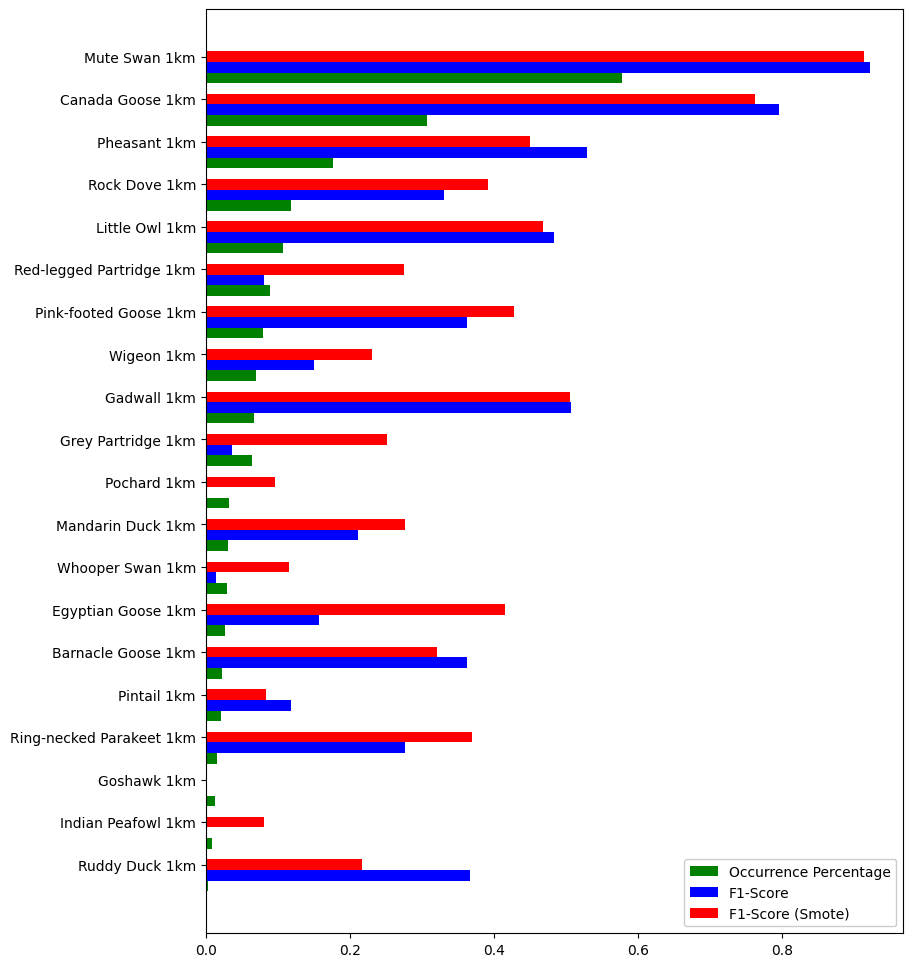

,Labels,F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 1km,0.921531,0.913311,19124,0.578044
1,Canada Goose 1km,0.795568,0.762464,10147,0.306704
10,Pheasant 1km,0.529246,0.450038,5855,0.176974
16,Rock Dove 1km,0.329925,0.391512,3919,0.118456
7,Little Owl 1km,0.483571,0.467473,3548,0.107242
14,Red-legged Partridge 1km,0.081218,0.275387,2953,0.089258
11,Pink-footed Goose 1km,0.362222,0.428094,2646,0.079978
19,Wigeon 1km,0.150665,0.230453,2317,0.070034
3,Gadwall 1km,0.506053,0.505792,2205,0.066649
5,Grey Partridge 1km,0.036430,0.251732,2123,0.064170


In [16]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 'F1': f1, 'F1 (Smote)': f1_smote,'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [20]:
# Store dictionaries for later use
df_dicts_1km_no_fp = df_dicts
%store df_dicts_1km_no_fp

Stored 'df_dicts_1km_no_fp' (list)


In [19]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/1km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '(without Fertiliser+Pesticides).csv')
    

,,Occurrence,Predictions
y,x,,
962500.0,155500.0,0,0
819500.0,338500.0,0,0
378500.0,406500.0,0,0
706500.0,390500.0,0,0
897500.0,325500.0,0,0
...,...,...,...
1096500.0,199500.0,0,0
535500.0,591500.0,0,0
337500.0,425500.0,0,0


,,Occurrence,Predictions
y,x,,
836500.0,116500.0,0,0
655500.0,626500.0,0,0
277500.0,451500.0,1,1
518500.0,61500.0,0,0
746500.0,117500.0,0,0
...,...,...,...
1017500.0,557500.0,0,0
374500.0,502500.0,1,0
248500.0,292500.0,0,1


,,Occurrence,Predictions
y,x,,
965500.0,565500.0,0,0
815500.0,297500.0,0,0
357500.0,224500.0,0,0
695500.0,254500.0,0,0
897500.0,689500.0,0,0
...,...,...,...
1097500.0,515500.0,0,0
516500.0,560500.0,0,0
315500.0,568500.0,0,0


,,Occurrence,Predictions
y,x,,
948500.0,472500.0,0,0
799500.0,389500.0,0,0
347500.0,652500.0,0,0
683500.0,615500.0,0,0
880500.0,575500.0,0,0
...,...,...,...
1086500.0,585500.0,0,0
499500.0,640500.0,0,0
312500.0,593500.0,0,0


,,Occurrence,Predictions
y,x,,
968500.0,51500.0,0,0
828500.0,230500.0,0,0
382500.0,480500.0,0,0
718500.0,624500.0,0,0
904500.0,666500.0,0,0
...,...,...,...
1099500.0,552500.0,0,0
540500.0,467500.0,0,0
337500.0,350500.0,0,0


,,Occurrence,Predictions
y,x,,
949500.0,6500.0,0,0
799500.0,470500.0,0,0
361500.0,282500.0,0,0
683500.0,278500.0,1,0
882500.0,446500.0,0,0
...,...,...,...
1091500.0,3500.0,0,0
505500.0,434500.0,0,1
323500.0,642500.0,0,1


,,Occurrence,Predictions
y,x,,
969500.0,180500.0,0,0
824500.0,179500.0,0,0
378500.0,407500.0,0,0
712500.0,336500.0,0,0
903500.0,422500.0,0,0
...,...,...,...
1099500.0,45500.0,0,0
531500.0,276500.0,0,0
334500.0,534500.0,0,0


,,Occurrence,Predictions
y,x,,
930500.0,568500.0,0,0
771500.0,130500.0,0,0
327500.0,11500.0,0,0
645500.0,485500.0,0,0
858500.0,506500.0,0,0
...,...,...,...
1074500.0,258500.0,0,0
456500.0,557500.0,0,0
293500.0,690500.0,0,0


,,Occurrence,Predictions
y,x,,
960500.0,209500.0,0,0
814500.0,197500.0,0,0
367500.0,436500.0,1,1
702500.0,371500.0,0,0
894500.0,360500.0,0,0
...,...,...,...
1096500.0,139500.0,0,0
521500.0,528500.0,0,0
325500.0,88500.0,0,0


,,Occurrence,Predictions
y,x,,
680500.0,65500.0,0,0
530500.0,309500.0,1,1
254500.0,634500.0,1,1
425500.0,348500.0,1,1
626500.0,529500.0,0,0
...,...,...,...
861500.0,205500.0,0,0
322500.0,344500.0,1,1
230500.0,483500.0,1,1


,,Occurrence,Predictions
y,x,,
902500.0,540500.0,0,0
739500.0,369500.0,0,0
317500.0,554500.0,0,0
622500.0,469500.0,0,0
828500.0,584500.0,0,0
...,...,...,...
1057500.0,582500.0,0,0
454500.0,632500.0,0,0
282500.0,318500.0,0,0


,,Occurrence,Predictions
y,x,,
950500.0,406500.0,0,0
809500.0,2500.0,0,0
398500.0,691500.0,0,0
707500.0,615500.0,0,0
881500.0,442500.0,0,0
...,...,...,...
1089500.0,549500.0,0,0
547500.0,154500.0,0,0
354500.0,260500.0,0,0


,,Occurrence,Predictions
y,x,,
967500.0,156500.0,0,1
822500.0,126500.0,0,0
378500.0,457500.0,0,0
709500.0,682500.0,0,0
900500.0,211500.0,0,0
...,...,...,...
1101500.0,468500.0,0,0
532500.0,374500.0,0,0
335500.0,560500.0,0,0


,,Occurrence,Predictions
y,x,,
961500.0,396500.0,0,0
818500.0,565500.0,0,0
371500.0,430500.0,0,0
704500.0,27500.0,0,0
896500.0,597500.0,0,0
...,...,...,...
1094500.0,461500.0,0,0
523500.0,617500.0,0,0
331500.0,11500.0,0,0


,,Occurrence,Predictions
y,x,,
940500.0,272500.0,0,0
782500.0,270500.0,0,0
336500.0,236500.0,0,0
664500.0,453500.0,0,0
868500.0,252500.0,0,0
...,...,...,...
1083500.0,173500.0,0,0
481500.0,553500.0,0,0
299500.0,527500.0,1,0


,,Occurrence,Predictions
y,x,,
969500.0,16500.0,0,0
821500.0,474500.0,0,0
368500.0,295500.0,0,0
709500.0,74500.0,0,0
903500.0,575500.0,0,0
...,...,...,...
1100500.0,390500.0,0,0
529500.0,393500.0,0,0
325500.0,323500.0,0,0


,,Occurrence,Predictions
y,x,,
937500.0,31500.0,0,0
778500.0,202500.0,0,0
335500.0,4500.0,0,0
659500.0,322500.0,1,0
863500.0,259500.0,1,0
...,...,...,...
1080500.0,155500.0,0,0
474500.0,477500.0,1,0
295500.0,95500.0,0,0


,,Occurrence,Predictions
y,x,,
969500.0,293500.0,0,0
825500.0,78500.0,0,0
379500.0,633500.0,0,0
713500.0,366500.0,0,0
901500.0,154500.0,0,0
...,...,...,...
1099500.0,316500.0,0,0
532500.0,141500.0,0,0
336500.0,138500.0,0,0


,,Occurrence,Predictions
y,x,,
965500.0,325500.0,1,0
825500.0,144500.0,1,0
386500.0,276500.0,0,1
713500.0,82500.0,0,0
903500.0,171500.0,0,0
...,...,...,...
1095500.0,145500.0,0,0
537500.0,428500.0,0,0
343500.0,467500.0,0,0


,,Occurrence,Predictions
y,x,,
952500.0,101500.0,0,0
810500.0,233500.0,0,0
374500.0,364500.0,1,0
698500.0,209500.0,0,0
884500.0,398500.0,0,0
...,...,...,...
1086500.0,454500.0,0,0
527500.0,207500.0,0,1
333500.0,528500.0,0,0


In [18]:
for dict in df_dicts:
    print(dict['name'])
    display(dict['kbest']['Dataframe'])

Barnacle Goose 1km


,F Score,P Value,Attribute
25,1586.660696,0.000000e+00,Inflowing drainage direction
18,1440.939379,1.143607e-308,Saltmarsh
23,1417.879628,7.271005e-304,Surface type
22,1269.611405,6.667737e-273,Cumulative catchment area
24,1223.198053,3.502336e-263,Outflowing drainage direction
21,1203.742558,4.196966e-259,Elevation
17,1078.608288,8.174358e-233,Littoral sediment
13,978.472706,1.050650e-211,Freshwater
15,853.811730,2.457887e-185,Supralittoral sediment
3,816.914586,1.639367e-177,Improve grassland


Canada Goose 1km


,F Score,P Value,Attribute
23,27980.651957,0.000000e+00,Surface type
24,22192.853532,0.000000e+00,Outflowing drainage direction
25,21798.073867,0.000000e+00,Inflowing drainage direction
21,20557.269520,0.000000e+00,Elevation
22,10467.973712,0.000000e+00,Cumulative catchment area
3,9373.992389,0.000000e+00,Improve grassland
20,6200.682674,0.000000e+00,Suburban
0,4606.437967,0.000000e+00,Deciduous woodland
2,4435.557422,0.000000e+00,Arable
19,2407.892997,0.000000e+00,Urban


Egyptian Goose 1km


,F Score,P Value,Attribute
22,4398.345684,0.000000e+00,Cumulative catchment area
13,3391.728526,0.000000e+00,Freshwater
24,2769.983626,0.000000e+00,Outflowing drainage direction
19,2688.563744,0.000000e+00,Urban
23,2448.189595,0.000000e+00,Surface type
25,1867.181758,0.000000e+00,Inflowing drainage direction
20,1608.119655,0.000000e+00,Suburban
21,1508.446202,1.037538e-322,Elevation
3,1160.254219,5.600729e-250,Improve grassland
0,1025.549798,1.228685e-221,Deciduous woodland


Gadwall 1km


,F Score,P Value,Attribute
24,5605.884628,0.000000e+00,Outflowing drainage direction
22,5421.221412,0.000000e+00,Cumulative catchment area
23,5337.742415,0.000000e+00,Surface type
25,4250.868883,0.000000e+00,Inflowing drainage direction
13,3657.950458,0.000000e+00,Freshwater
21,3513.520144,0.000000e+00,Elevation
2,2555.774940,0.000000e+00,Arable
3,2162.540101,0.000000e+00,Improve grassland
20,1871.462238,0.000000e+00,Suburban
0,1487.487019,2.357158e-318,Deciduous woodland


Goshawk 1km


,F Score,P Value,Attribute
23,1228.008833,3.437230e-264,Surface type
21,1131.658994,5.687958e-244,Elevation
24,1068.037277,1.373575e-230,Outflowing drainage direction
22,1044.933301,1.009602e-225,Cumulative catchment area
25,919.889067,2.517246e-199,Inflowing drainage direction
0,809.818171,5.254241e-176,Deciduous woodland
3,684.780108,2.032079e-149,Improve grassland
1,397.809147,5.441281e-88,Coniferous woodland
6,362.459808,2.209967e-80,Acid grassland
2,87.757391,7.852555e-21,Arable


Grey Partridge 1km


,F Score,P Value,Attribute
2,8141.700589,0.000000e+00,Arable
23,5901.470556,0.000000e+00,Surface type
24,4800.409421,0.000000e+00,Outflowing drainage direction
22,4601.906150,0.000000e+00,Cumulative catchment area
25,4463.973740,0.000000e+00,Inflowing drainage direction
21,4389.262340,0.000000e+00,Elevation
3,2126.495399,0.000000e+00,Improve grassland
0,901.238763,2.221379e-195,Deciduous woodland
20,518.009891,8.599298e-114,Suburban
5,327.045266,9.488789e-73,Calcareous grassland


Indian Peafowl 1km


,F Score,P Value,Attribute
23,826.341713,1.639780e-179,Surface type
22,773.116357,3.264405e-168,Cumulative catchment area
24,694.651908,1.603430e-151,Outflowing drainage direction
2,636.396656,4.208646e-139,Arable
25,618.098698,3.386540e-135,Inflowing drainage direction
21,581.270648,2.497700e-127,Elevation
3,579.289817,6.621914e-127,Improve grassland
0,557.985251,2.382356e-122,Deciduous woodland
20,341.361921,7.768283e-76,Suburban
4,31.037453,2.550632e-08,Neutral grassland


Little Owl 1km


,F Score,P Value,Attribute
23,9941.994917,0.000000e+00,Surface type
2,9462.794504,0.000000e+00,Arable
24,8442.661824,0.000000e+00,Outflowing drainage direction
22,7788.899641,0.000000e+00,Cumulative catchment area
25,7508.970331,0.000000e+00,Inflowing drainage direction
21,6742.553493,0.000000e+00,Elevation
3,4944.473615,0.000000e+00,Improve grassland
20,2250.993774,0.000000e+00,Suburban
0,1224.086080,2.281664e-263,Deciduous woodland
4,630.020519,9.656906e-138,Neutral grassland


Mandarin Duck 1km


,F Score,P Value,Attribute
22,3559.780952,0.000000e+00,Cumulative catchment area
0,3525.975295,0.000000e+00,Deciduous woodland
24,2973.634105,0.000000e+00,Outflowing drainage direction
23,2900.268149,0.000000e+00,Surface type
3,2556.207049,0.000000e+00,Improve grassland
25,2139.256963,0.000000e+00,Inflowing drainage direction
21,2040.599063,0.000000e+00,Elevation
20,1659.981195,0.000000e+00,Suburban
13,792.705495,2.254877e-172,Freshwater
19,434.160164,8.347169e-96,Urban


Mute Swan 1km


,F Score,P Value,Attribute
23,41778.683149,0.000000e+00,Surface type
25,37707.864005,0.000000e+00,Inflowing drainage direction
21,32149.803935,0.000000e+00,Elevation
24,24629.730532,0.000000e+00,Outflowing drainage direction
22,7714.991172,0.000000e+00,Cumulative catchment area
3,6922.429433,0.000000e+00,Improve grassland
20,5556.769597,0.000000e+00,Suburban
2,4548.309043,0.000000e+00,Arable
0,3188.833827,0.000000e+00,Deciduous woodland
19,2126.916337,0.000000e+00,Urban


Pheasant 1km


,F Score,P Value,Attribute
23,14828.439300,0.000000e+00,Surface type
24,12411.664397,0.000000e+00,Outflowing drainage direction
21,11511.436305,0.000000e+00,Elevation
25,11025.748971,0.000000e+00,Inflowing drainage direction
22,9363.861895,0.000000e+00,Cumulative catchment area
3,6889.758402,0.000000e+00,Improve grassland
2,5020.115469,0.000000e+00,Arable
0,3497.652887,0.000000e+00,Deciduous woodland
20,1872.691498,0.000000e+00,Suburban
5,415.858475,7.152889e-92,Calcareous grassland


Pink-footed Goose 1km


,F Score,P Value,Attribute
25,5823.246006,0.000000e+00,Inflowing drainage direction
23,5796.329675,0.000000e+00,Surface type
21,4750.062797,0.000000e+00,Elevation
24,4416.411546,0.000000e+00,Outflowing drainage direction
22,4111.240745,0.000000e+00,Cumulative catchment area
2,4027.385455,0.000000e+00,Arable
17,1680.756257,0.000000e+00,Littoral sediment
3,1578.759585,0.000000e+00,Improve grassland
18,1503.642898,1.032597e-321,Saltmarsh
20,1109.115857,3.118895e-239,Suburban


Pintail 1km


,F Score,P Value,Attribute
25,1325.168183,1.608067e-284,Inflowing drainage direction
23,1169.840995,5.439990e-252,Surface type
21,987.248175,1.475675e-213,Elevation
24,832.260391,9.109264e-181,Outflowing drainage direction
18,829.398253,3.685447e-180,Saltmarsh
22,760.526243,1.546155e-165,Cumulative catchment area
2,723.168873,1.361610e-157,Arable
17,700.432781,9.417029e-153,Littoral sediment
3,435.362823,4.604501e-96,Improve grassland
20,333.610377,3.643021e-74,Suburban


Pochard 1km


,F Score,P Value,Attribute
23,1842.761284,0.000000e+00,Surface type
2,1555.536108,0.000000e+00,Arable
25,1549.051565,0.000000e+00,Inflowing drainage direction
24,1485.853766,5.152527e-318,Outflowing drainage direction
22,1392.732967,1.268634e-298,Cumulative catchment area
21,1309.187405,3.516732e-281,Elevation
20,894.234195,6.746925e-194,Suburban
3,745.160492,2.857352e-162,Improve grassland
19,743.681811,5.893993e-162,Urban
0,574.470893,7.099727e-126,Deciduous woodland


Red-legged Partridge 1km


,F Score,P Value,Attribute
2,9262.561980,0.000000e+00,Arable
23,8310.347324,0.000000e+00,Surface type
24,6580.468060,0.000000e+00,Outflowing drainage direction
25,6132.393216,0.000000e+00,Inflowing drainage direction
21,6122.856668,0.000000e+00,Elevation
22,6094.072173,0.000000e+00,Cumulative catchment area
3,3761.382336,0.000000e+00,Improve grassland
0,1821.322033,0.000000e+00,Deciduous woodland
20,591.420483,1.691353e-129,Suburban
5,325.757650,1.798558e-72,Calcareous grassland


Ring-necked Parakeet 1km


,F Score,P Value,Attribute
20,5174.029480,0.000000e+00,Suburban
19,4816.293327,0.000000e+00,Urban
22,2110.055997,0.000000e+00,Cumulative catchment area
23,1451.182004,8.429407e-311,Surface type
24,1239.102083,1.629495e-266,Outflowing drainage direction
25,1101.552188,1.215523e-237,Inflowing drainage direction
21,934.465809,2.082605e-202,Elevation
0,644.695315,7.138206e-141,Deciduous woodland
3,590.530935,2.620156e-129,Improve grassland
13,266.908247,9.184502e-60,Freshwater


Rock Dove 1km


,F Score,P Value,Attribute
23,9715.208896,0.000000e+00,Surface type
24,7716.649425,0.000000e+00,Outflowing drainage direction
25,7489.623513,0.000000e+00,Inflowing drainage direction
21,7209.182719,0.000000e+00,Elevation
22,6950.626400,0.000000e+00,Cumulative catchment area
3,4736.971375,0.000000e+00,Improve grassland
20,4361.914241,0.000000e+00,Suburban
2,3272.566853,0.000000e+00,Arable
0,1947.276915,0.000000e+00,Deciduous woodland
19,1698.722674,0.000000e+00,Urban


Ruddy Duck 1km


,F Score,P Value,Attribute
13,2084.023887,0.000000e+00,Freshwater
24,574.800456,6.036397e-126,Outflowing drainage direction
22,439.953763,4.753911e-97,Cumulative catchment area
23,331.644948,9.666367e-74,Surface type
25,252.505585,1.196889e-56,Inflowing drainage direction
19,209.791045,2.131385e-47,Urban
21,206.348108,1.188914e-46,Elevation
0,197.545829,9.644094e-45,Deciduous woodland
4,178.469812,1.333079e-40,Neutral grassland
3,159.658114,1.632226e-36,Improve grassland


Whooper Swan 1km


,F Score,P Value,Attribute
25,1676.560528,0.000000e+00,Inflowing drainage direction
23,1555.884294,0.000000e+00,Surface type
21,1411.884325,1.291051e-302,Elevation
24,1295.050837,3.175931e-278,Outflowing drainage direction
22,1252.169594,2.987125e-269,Cumulative catchment area
3,560.870223,5.752589e-123,Improve grassland
2,518.099739,8.226528e-114,Arable
13,302.457075,1.918026e-67,Freshwater
17,294.097064,1.224555e-65,Littoral sediment
0,236.168141,4.111276e-53,Deciduous woodland


Wigeon 1km


,F Score,P Value,Attribute
25,4543.858943,0.000000e+00,Inflowing drainage direction
23,4385.352401,0.000000e+00,Surface type
21,3772.569210,0.000000e+00,Elevation
24,3296.213107,0.000000e+00,Outflowing drainage direction
22,3018.447019,0.000000e+00,Cumulative catchment area
3,1984.684092,0.000000e+00,Improve grassland
2,1640.404091,0.000000e+00,Arable
0,1016.533733,9.783489e-220,Deciduous woodland
20,871.988879,3.462062e-189,Suburban
17,839.439277,2.736586e-182,Littoral sediment
